<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Экспорт-датасета" data-toc-modified-id="Экспорт-датасета-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Экспорт датасета</a></span></li><li><span><a href="#Деление-на-выборки" data-toc-modified-id="Деление-на-выборки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Деление на выборки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

!pip install nltk

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np 

import nltk
from nltk.stem import WordNetLemmatizer # лемматизатор для английского текста
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score

from time import time
from tqdm import tqdm

import sys
import spacy

from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.naive_bayes import GaussianNB
from sklearn import svm

#адаптивный бустинг

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier

Устанавливаю Spacy. После установки перевёл в Markdown, чтобы каждый раз не запускалась

!{sys.executable} -m pip install spacy  
!{sys.executable} -m spacy download en

In [4]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
    
except:
    
    data = pd.read_csv("W:/Anaconda/Data Science/datasets/toxic_comments.csv")
    
data.head(20)    

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


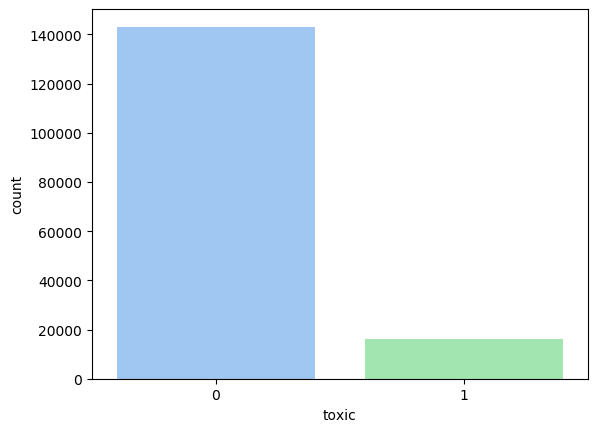

In [5]:
# Посмотрю на распределение токсичных комментариев
sns.countplot(data=data, x="toxic")

Данные не сбалансированы. Нужно выполнять стратификацию при разделении на выборки.

Подгрузим файлы для английской библиотеки лемматизатора

In [53]:
nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('averaged_perceptron_tagger') # усредненный тригер
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\granu\anaconda3\
[nltk_data]     envs\praktikum_env_win_new\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to C:\Users\granu\anaconda3\envs
[nltk_data]     \praktikum_env_win_new\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\granu\anaconda3\en
[nltk_data]     vs\praktikum_env_win_new\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to C:\Users
[nltk_data]     \granu\anaconda3\envs\praktikum_env_win_new\nltk_data.
[nltk_data]     ..
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


### Лемматизация

Проведём очистку текста, где должны остаться только слова, без символов.

In [24]:
# функция для очистки текста
def clear_text(text):
    regular = re.sub(r'[^a-zA-Z]',' ', text.lower()) #преобразование и перевод в нижний регистр
    split = regular.split()
    join = ' '.join(split)
    return join

Пришлось выбрать другой метод, т.к. SpaCy будет лемматизировать около 17 часов
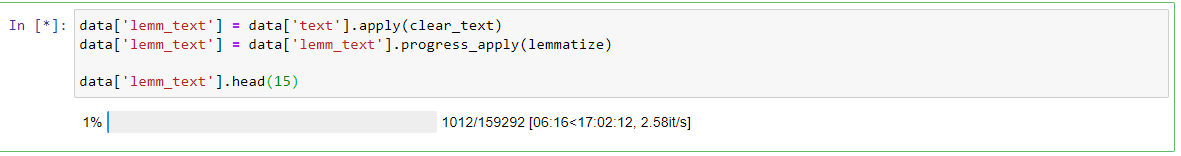

Проверка SpaCy на тестовом тексте:

In [49]:
nlp_test = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
sentence = "The striped bats are hanging on their feet for best"
doc_test = nlp_test(sentence)
lemma = " ".join([token.lemma_ for token in doc_test])
print('Оригинальный текст:', doc_test)
print('Лемма:', lemma)

Оригинальный текст: The striped bats are hanging on their feet for best
Лемма: the stripe bat be hang on their foot for good


Проверка Wordnet Lemmatizer с соответствующим POS-тегом на тестовом тексте:

In [82]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [83]:
lemmatizer = WordNetLemmatizer()

In [84]:
sentence = "The striped bats are hanging on their feet for best"

In [85]:
lemm_sent = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
lemm_sent = ' '.join(lemm_sent)
lemm_sent

'The strip bat be hang on their foot for best'

In [86]:

def lemm_text(text):
    word_list = nltk.word_tokenize(text) 
    return ' '.join(lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text))

In [90]:
%%time
data['lemm_text'] = data['text'].progress_apply(clear_text)
data['lemm_text'] = data['text'].progress_apply(lemm_text)
data['lemm_text'].head()

  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

Wall time: 55min 46s


0    Explanation Why the edits make under my userna...
1    D'aww ! He match this background colour I 'm s...
2    Hey man , I 'm really not try to edit war . It...
3    `` More I ca n't make any real suggestion on i...
4    You , sir , be my hero . Any chance you rememb...
Name: lemm_text, dtype: object

### Экспорт датасета

In [93]:
#скачаю датасет, чтобы не потерять прогресс
data.to_csv('toxic_comments_with_lemmas.csv', index=False) 

In [2]:
data = pd.read_csv("W:/Anaconda/Data Science/datasets/toxic_comments_with_lemmas.csv")

### Деление на выборки

Разделим данные на тренировочную и тестовую выборку. Перед этим выделим обучающие и целевые признаки.

In [3]:
features = data.drop('toxic', axis = 1)
target = data['toxic']

train_features, test_features, train_target, test_target = train_test_split(
    features,
    target,
    test_size=0.1,
    random_state=12345,
    stratify=data['toxic'] # стратифицируем текст, чтобы выборки были более сбалансированы
)

# вытаскиваем корпусы
corpus_train = train_features['lemm_text']
corpus_test = test_features['lemm_text']
corpus_train.head(15)

92651     A thing At time , the moan of Birkin/Bardot be...
57776     Re : suicide . I 'm go to take my advice and s...
155506                               Archive to 08 Dec 2006
14143     `` Hello , the tag be add because : The articl...
128218    `` Good morning . Look where the satanic comme...
82216     `` : : : : : Your comment above unfortunately ...
101422    `` Done , ive retract that comment . It seem t...
114959    Ghosh 1 June 2013 Please add source with and n...
120843    `` Have to disagree , Obama fell for a few key...
29149     `` I also ask whether you be give an assessmen...
136106    `` BTW give a reference be usually to an exter...
44645              I explain to you but you get it delete !
37949     Hi . There be a Korean remake of Ringu , and I...
60783     Chopin and Balakirev I be surprised that Chopi...
151940    What be this comunist shit on continuation war...
Name: lemm_text, dtype: object

Создадим мешок слов и уберём из него стоп-слова, которые были загружены для английского языка

In [4]:
stopwords = set(nltk_stopwords.words('english'))

In [5]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords))

tf_idf_train = tfidf_vectorizer.fit_transform(corpus_train) # обучение на тренировочной выборке и преобразование
tf_idf_test = tfidf_vectorizer.transform(corpus_test) # преобразование тестовой выборки
print(f'Размер тренировочной выборки: {tf_idf_train.shape}')
print(f'Размер тестовой выборки: {tf_idf_test.shape}')

Размер тренировочной выборки: (143362, 170338)
Размер тестовой выборки: (15930, 170338)


- Разделили данные. 
- Получили TF-IDF.   
Можно приступать к обучению моделей

## Обучение

Для обучения возьмём следующие модели:  
1. Логистическая регрессия
2. Дерево решений
3. Случайный лес
4. Градиентный бустинг

In [31]:
# для подсчёта сравнения результатов, создадим таблицу, куда будут записываться полученные значения
analisys = pd.DataFrame({'model':[], 'F1_model':[]})
all_models = []

In [32]:
def train_model(model, parameters):
    
    model_random = RandomizedSearchCV(
        estimator=model,
        param_distributions=parameters,
        scoring='f1', 
        n_jobs=-1,
        cv=4, 
        verbose=2
    )
    
    # подсчитаем скорость вычисления
    start = time()
    model_random.fit(tf_idf_train, train_target)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))
    
    # высчитаем метрики
    f1 = model_random.best_score_

    
    print('Лучшие параметры:', model_random.best_params_)
    print('F1 обученной модели:', f1)

    # заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, f1])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

### Логистическая регрессия

In [33]:
regres_parammetrs = {
    "penalty": ['l2'],
    "class_weight": ['balanced'],
    "C":[5,15]
}

logr = LogisticRegression(max_iter=1000)

lr_random = train_model(logr, regres_parammetrs) # обучим и сохраним значения

C:\Users\granu\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 4 folds for each of 2 candidates, totalling 8 fits
RandomizedSearchCV подбирал параметры 26.15 секунд
Лучшие параметры: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 5}
F1 обученной модели: 0.7594260090012956


### Дерево решений

In [34]:
tree_param = {"max_depth": list(range(50, 60))
}
tree = DecisionTreeClassifier()

dtr_random = train_model(tree, tree_param)          

Fitting 4 folds for each of 10 candidates, totalling 40 fits
RandomizedSearchCV подбирал параметры 111.08 секунд
Лучшие параметры: {'max_depth': 59}
F1 обученной модели: 0.6993468100356794


### Случайный лес

In [35]:
# зададим рандомные параметры

ran_grid_forest = {
    'max_depth': [ 310, 320],
    'n_estimators': [10, 13],
}

rfc = RandomForestClassifier(n_jobs=-1)

rfc_random = train_model(rfc, ran_grid_forest) # обучим и сохраним значения

Fitting 4 folds for each of 4 candidates, totalling 16 fits


C:\Users\granu\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV подбирал параметры 72.32 секунд
Лучшие параметры: {'n_estimators': 10, 'max_depth': 310}
F1 обученной модели: 0.5886224225318513


### LightGBM

In [36]:
rand_lgbm_param = {
    'max_depth': [25, 35],
    'learning_rate': [0.3]
}

gbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_jobs=-1
)

gbm_random= train_model(gbm, rand_lgbm_param)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


C:\Users\granu\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV подбирал параметры 44.91 секунд
Лучшие параметры: {'max_depth': 35, 'learning_rate': 0.3}
F1 обученной модели: 0.7641973800460384


### XGBoost

In [37]:
rand_xgb_param = {
    'max_depth': [9, 15],
    'learning_rate': [0.5]
}

xb = xgb.XGBClassifier(booster='gbtree', 
                      use_rmm=True,
                      n_jobs=-1)

xb_random = train_model(xb, rand_xgb_param)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


C:\Users\granu\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV подбирал параметры 185.30 секунд
Лучшие параметры: {'max_depth': 15, 'learning_rate': 0.5}
F1 обученной модели: 0.759039846519746


In [38]:
all_names = pd.DataFrame({'names':[ 'LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)


,model,F1_model,names
0,LogisticRegression(max_iter=1000),0.759426,LogisticRegression
1,DecisionTreeClassifier(),0.699347,DecisionTree
2,RandomForestClassifier(n_jobs=-1),0.588622,RandomForest
3,LGBMClassifier(),0.764197,LightGBM
4,"XGBClassifier(base_score=None, booster='gbtree...",0.759040,XGBoost


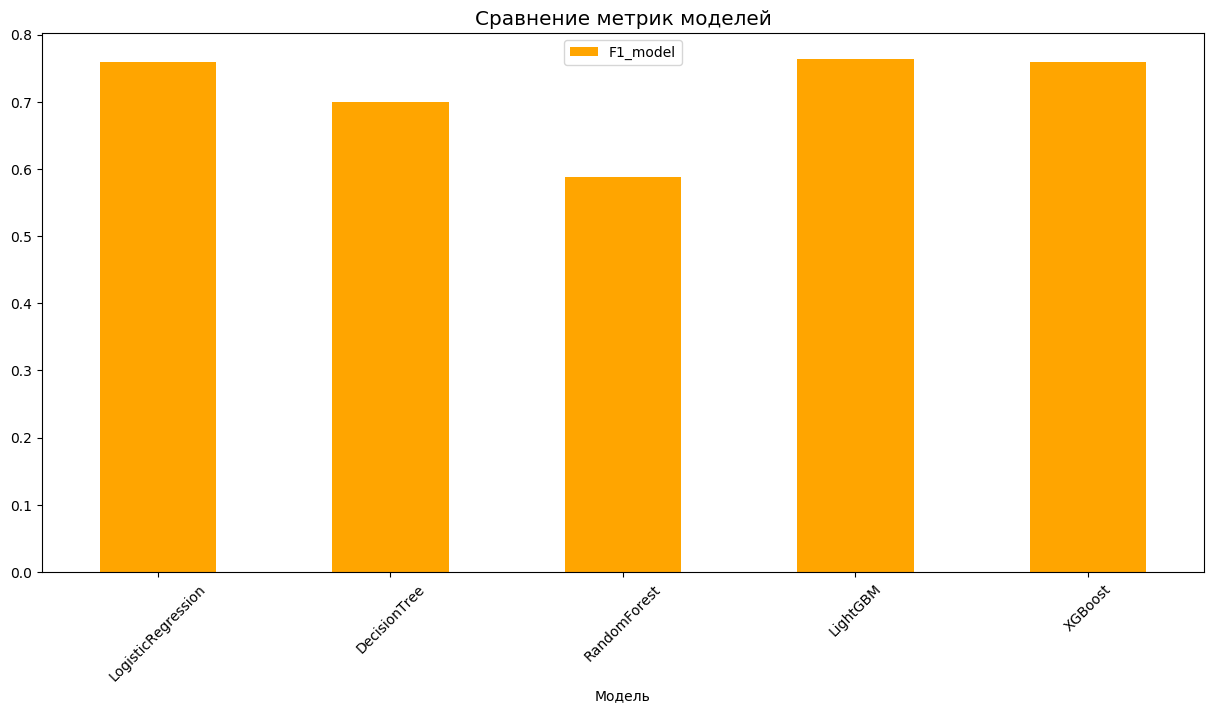

In [39]:
analisys.plot.bar(y='F1_model', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

В для тестовой выборки выбираю `LightGBM`, т.к. у него наивысший параметр F1 score равный 0.764.

In [41]:
predicted = gbm_random.predict(tf_idf_test)
print('F1 лучшей модели на тестовой выборке:', f1_score(test_target, predicted))

F1 лучшей модели на тестовой выборке: 0.7711598746081505


## Выводы

Самая лучшая модель `LightGBM`. На тестовой выборки `F1` её равняется 0.77, что удовлетворяет условию F1 > 0.75